In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az

sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")

In [3]:
data_1 = pd.read_csv(r"data_01.csv")
data_2 = pd.read_csv(r"data_02.csv")
data_3 = pd.read_csv(r"data_03.csv")
data_4 = pd.read_csv(r"data_04.csv")
data_5 = pd.read_csv(r"data_05.csv")
data_6 = pd.read_csv(r"data_06.csv")

In [4]:
datasets = [data_1, data_2, data_3, data_4, data_5, data_6]

In [5]:
all_data = pd.concat(datasets, keys=range(len(datasets)))
all_data['dataset_idx'] = np.repeat(range(len(datasets)), [len(df) for df in datasets])

M = len(datasets)
N = len(all_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [α_μ_tmp, α_σ_tmp, β_μ, β_σ, α_tmp, β, ε, ν]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 50 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


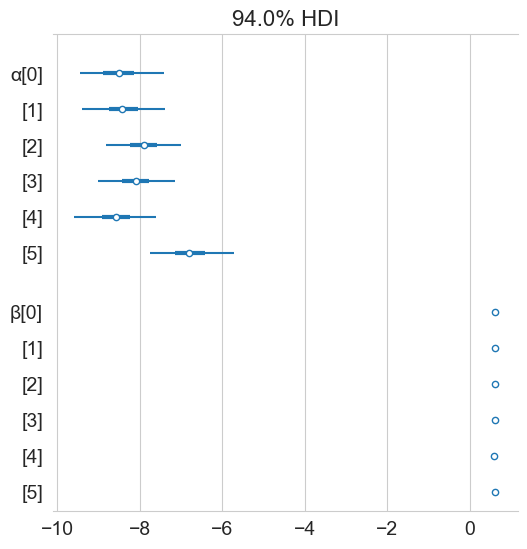

In [6]:
with pm.Model() as hierarchical_model:
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0, sigma=5)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', sigma=3)
    β_μ = pm.Normal('β_μ', mu=0, sigma=2)
    β_σ = pm.HalfNormal('β_σ', sigma=2)

    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sigma=α_σ_tmp, shape=len(datasets))
    β = pm.Normal('β', mu=β_μ, sigma=β_σ, shape=len(datasets))
    ε = pm.HalfCauchy('ε', 2)
    ν = pm.Normal('ν', 1/12)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[all_data['dataset_idx']] + β[all_data['dataset_idx']] * all_data['x'].values,
                         sigma=ε, nu=ν, observed=all_data['y'].values)

    α = pm.Deterministic('α', α_tmp - β * all_data.groupby('dataset_idx').mean()['x'].values)
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * all_data.groupby('dataset_idx').mean()['x'].values)
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * all_data.groupby('dataset_idx').mean()['x'].values)

    trace_hm = pm.sample(1000, target_accept=0.95)

# Отобразите результаты
az.plot_forest(trace_hm, var_names=['α', 'β'], combined=True);

In [7]:
az.summary(trace_hm)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α_μ_tmp,0.898,0.271,0.405,1.391,0.013,0.009,428.0,889.0,1.01
β_μ,0.609,0.017,0.577,0.639,0.001,0.001,431.0,892.0,1.01
α_tmp[0],1.005,0.287,0.492,1.583,0.014,0.010,439.0,645.0,1.01
α_tmp[1],0.978,0.284,0.455,1.519,0.014,0.010,419.0,816.0,1.02
α_tmp[2],0.809,0.266,0.304,1.274,0.012,0.009,454.0,724.0,1.00
α_tmp[3],0.881,0.261,0.373,1.358,0.012,0.009,444.0,721.0,1.01
α_tmp[4],0.739,0.277,0.185,1.218,0.012,0.009,500.0,988.0,1.01
α_tmp[5],0.967,0.364,0.273,1.626,0.015,0.011,556.0,1034.0,1.01
β[0],0.611,0.018,0.578,0.643,0.001,0.001,465.0,842.0,1.01
β[1],0.610,0.017,0.578,0.642,0.001,0.001,456.0,816.0,1.01


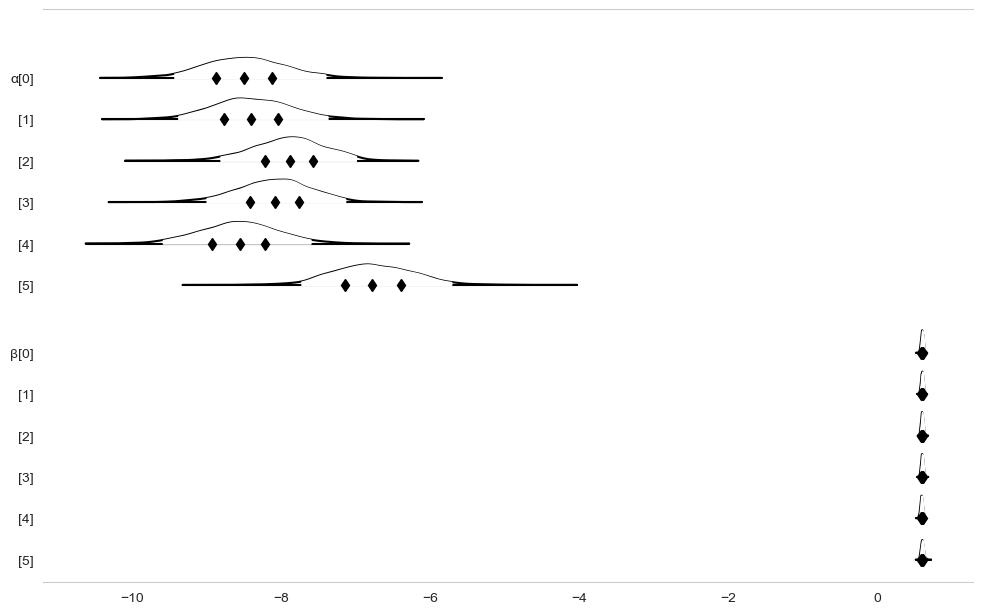

In [8]:
az.plot_forest(trace_hm, var_names=['α', 'β'],kind ='ridgeplot',
               combined=True,
               ridgeplot_truncate=False,
               ridgeplot_quantiles=[.25, .5, .75],
               ridgeplot_overlap=0.7,
               colors='white');

array([[<Axes: title={'center': 'α_μ_tmp'}>,
        <Axes: title={'center': 'β_μ'}>,
        <Axes: title={'center': 'α_tmp\n0'}>,
        <Axes: title={'center': 'α_tmp\n1'}>],
       [<Axes: title={'center': 'α_tmp\n2'}>,
        <Axes: title={'center': 'α_tmp\n3'}>,
        <Axes: title={'center': 'α_tmp\n4'}>,
        <Axes: title={'center': 'α_tmp\n5'}>],
       [<Axes: title={'center': 'β\n0'}>,
        <Axes: title={'center': 'β\n1'}>,
        <Axes: title={'center': 'β\n2'}>,
        <Axes: title={'center': 'β\n3'}>],
       [<Axes: title={'center': 'β\n4'}>,
        <Axes: title={'center': 'β\n5'}>, <Axes: title={'center': 'ν'}>,
        <Axes: title={'center': 'α_σ_tmp'}>],
       [<Axes: title={'center': 'β_σ'}>, <Axes: title={'center': 'ε'}>,
        <Axes: title={'center': 'α\n0'}>,
        <Axes: title={'center': 'α\n1'}>],
       [<Axes: title={'center': 'α\n2'}>,
        <Axes: title={'center': 'α\n3'}>,
        <Axes: title={'center': 'α\n4'}>,
        <Axes: title={'

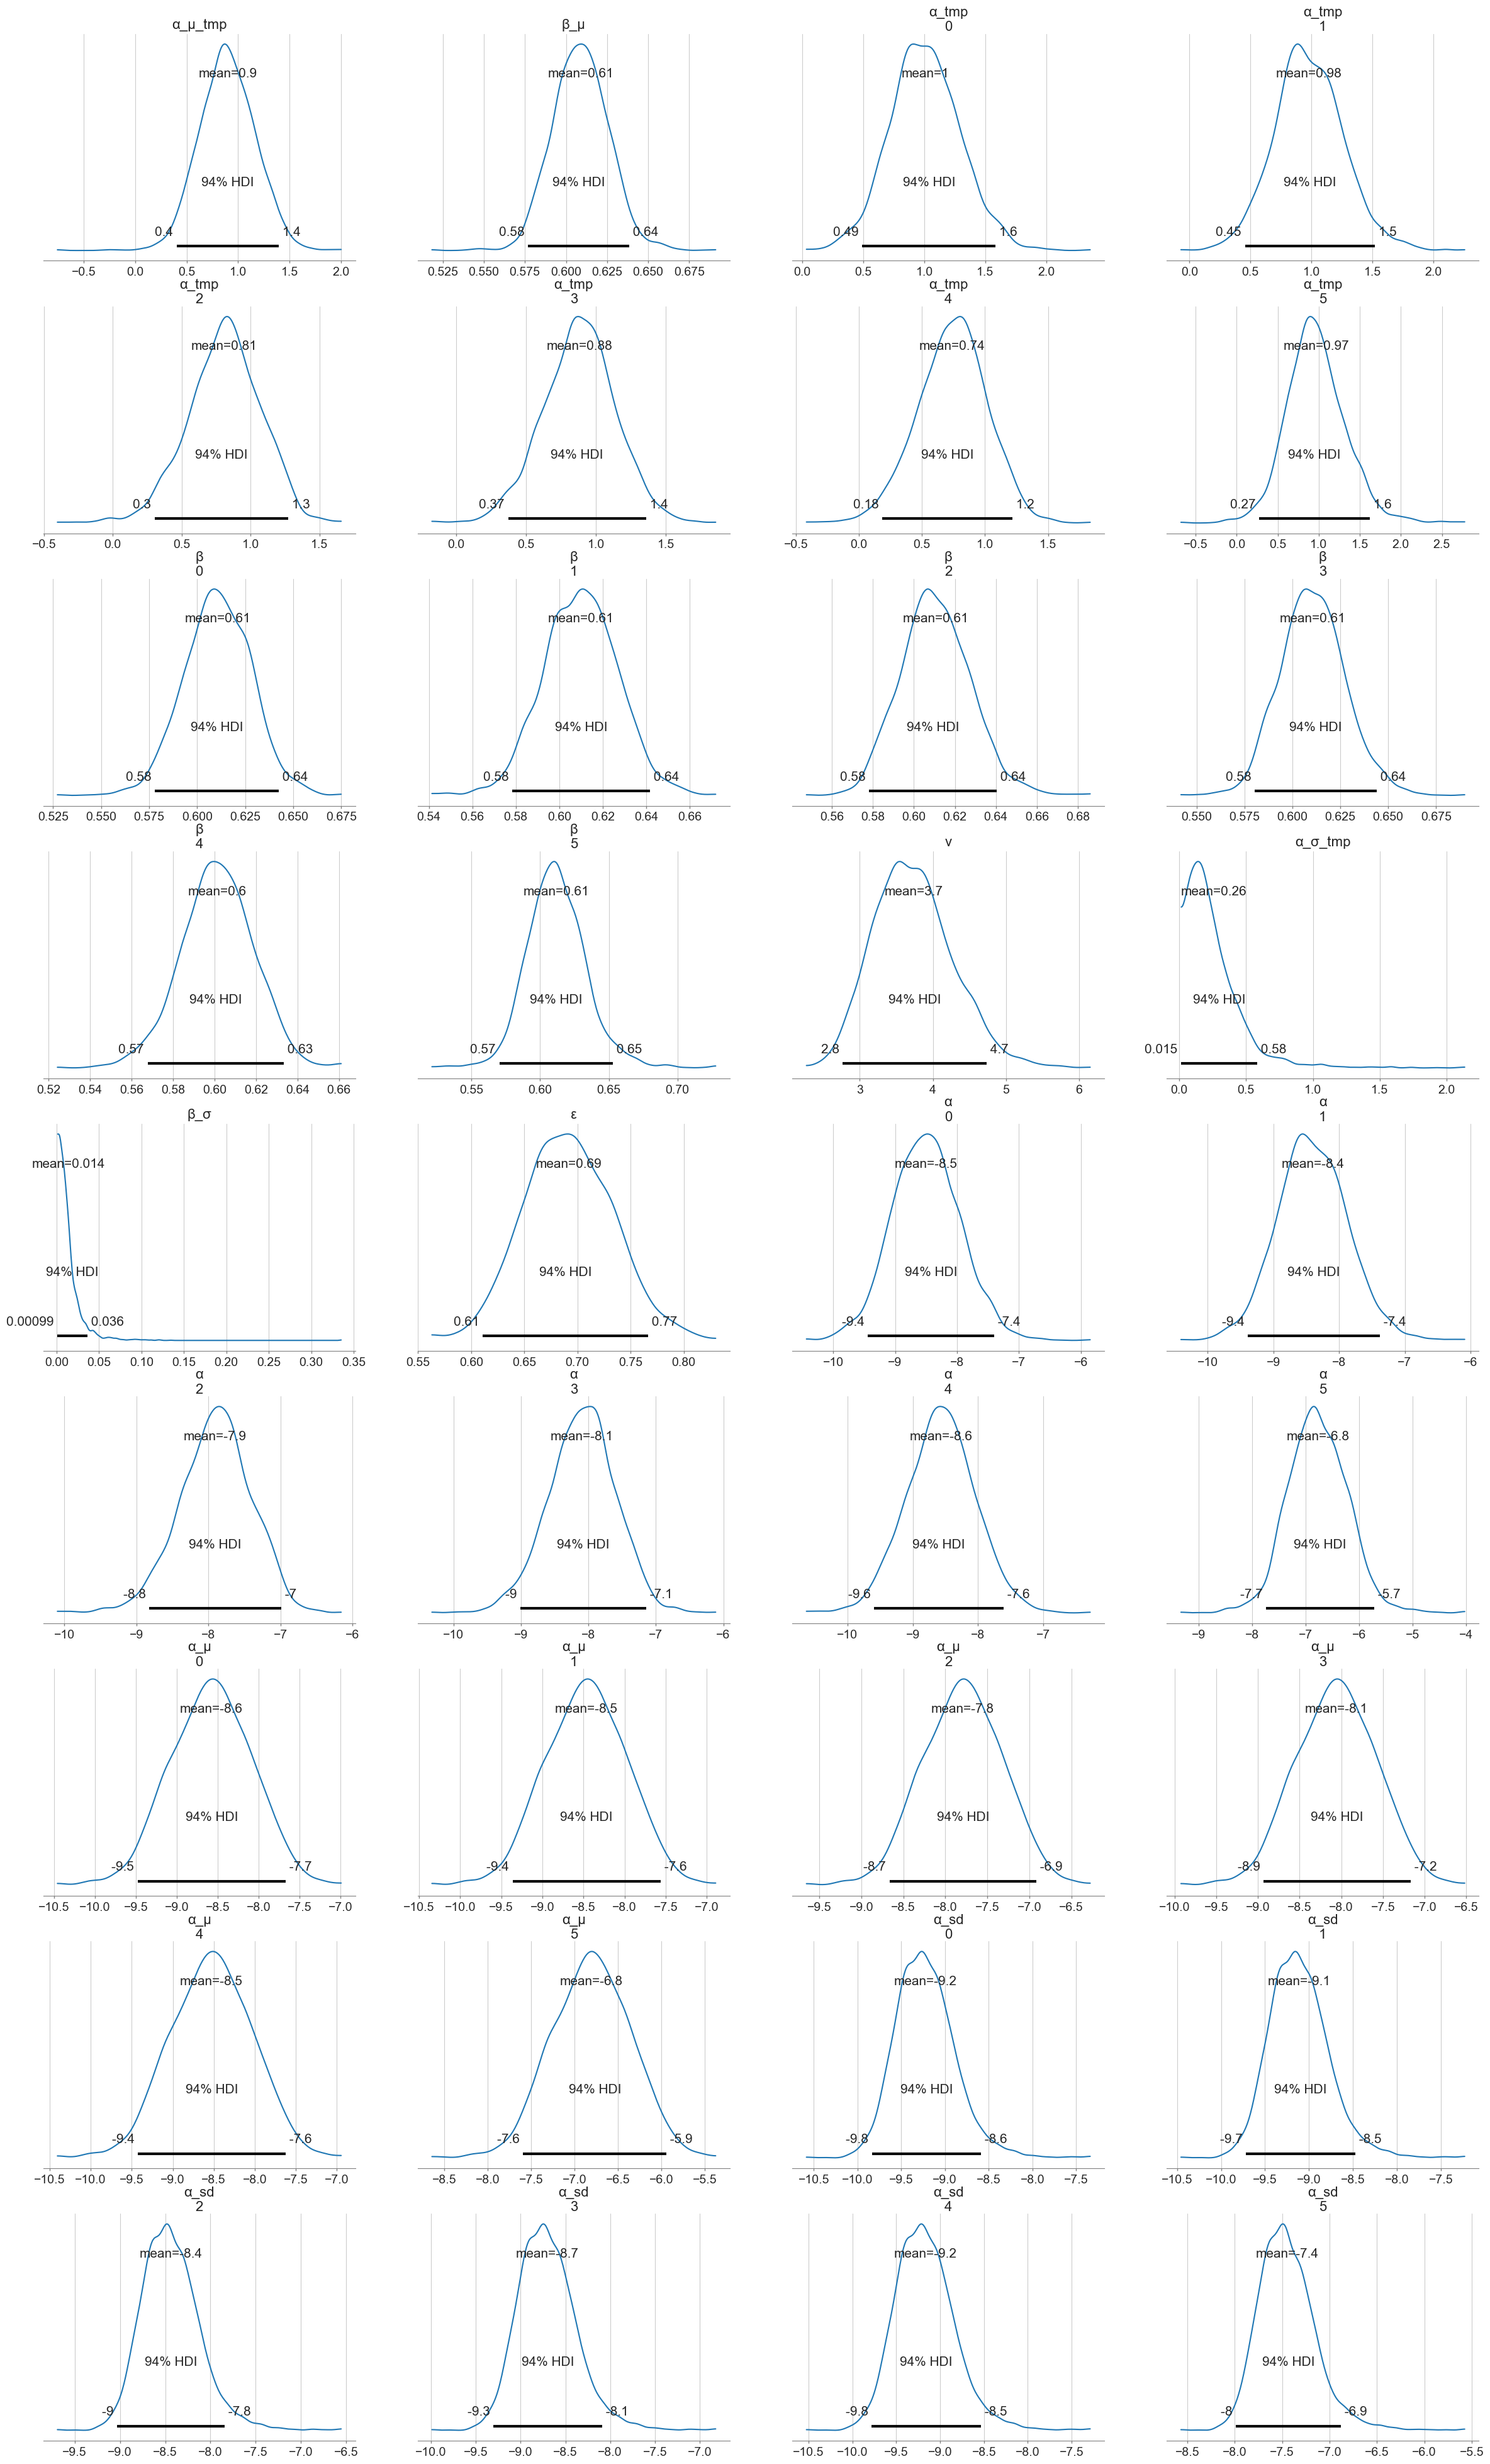

In [9]:
pm.plot_posterior(trace_hm)

In [10]:
 posterior = pm.sample_posterior_predictive(trace_hm, model = hierarchical_model)

Sampling: [y_pred]
